## Problema do prof. Castelano

Diferential Equation:
$$
\frac{dx(t)}{dt} +\frac{x(t)}{\tau} - g(t) = 0
$$

with 
$$
g(t) = c_1 V(t) + c_2V^2(t)
\\
I(t) =[ a +bx(t) ] V(t),
\\
V(t) = V_0*cos(wt),
$$

we want learning the $c_1$ and $c_2$. Simplifying the equations :
$$
\frac{dx(t)}{dt} +\frac{x(t)}{\tau} -  c_1  V_0*cos(wt) - c_2 V_0^2*cos^2(wt) = 0
$$

with 
$$
I(t) =V_0[ a +bx(t) ]cos(wt),
$$


## ..

In [1]:
#from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

In [2]:
class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            #self.acceleration = nn.Parameter(tc.rand(N_of_paramater))
            self.acceleration = nn.Parameter(tc.ones(N_of_paramater)*2)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


Lets consider  a = 4, b = 2, $V_0$ = 1 , $\tau$ = 1 e $w$ = $1/\tau$ =1 then 

$$
Loss_{edo} = \frac{dx(t)}{dt} + x(t)  - c_1 data_{V(t)} - c_2[data_{V(t)}]^2  
$$

and   
$$
Loss_{data} =  data_{I(t)} - [ 4 +2x(t) ] data_{V(t)}
$$

The time range is $[0,2\pi]$

In [3]:
def analitics_solution(N,a,b,c1,c2,V0,tau):
    w  = 1/(tau)
    dt = 2*np.pi/N
    
    def F(w,t,c1,c2):
        p  = tau*w
        d1 = 2*(1+(p)**2)
        d2 = (1+(2*p)**2)
        return c1*tau*V0/d1*(np.cos(w*t) + p*np.sin(w*t))+c2*tau*V0**2/2*(1+1/d2*(np.cos(2*w*t)+2*p*np.sin(2*w*t)))
    n = np.zeros(N+1)
    I = np.zeros(N+1)
    V = np.zeros(N+1)
    t = np.zeros(N+1)
    for i in range(N+1):
        t[i]=(i)*dt
        V[i]=V0*np.cos(w*t[i])
        I[i]=(a+b*F(w,t[i],c1,c2))*V[i]
    return t,I,V

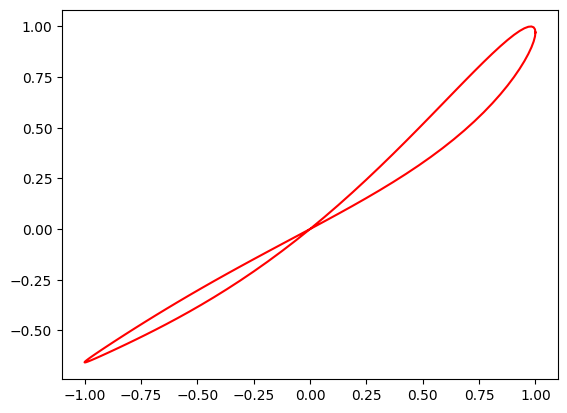

In [4]:
time,corrent,d_potencial = analitics_solution(N=100,a=4,b=2,c1=2.0,c2=1.0,V0=1,tau=1)

plt.plot(d_potencial/d_potencial.max(),corrent/corrent.max(),"r-",label='Predict')

# Aprendendo os parametros a, b, C_1 e C_2

In [5]:
def traino(lr_,neuronio_,camadas,fun_activation,epochs=1000):
    # Criando os dados de treino
    time,corrent,d_potencial = analitics_solution(N=100,a=4,b=2,c1=2.0,c2=1.0,V0=1,tau=1)

    t_train = tc.tensor(time,requires_grad=True,dtype=tc.float).reshape(-1,1)
    I_data  = tc.tensor(corrent,dtype=tc.float).reshape(-1,1)
    V_data  = tc.tensor(d_potencial,dtype=tc.float).reshape(-1,1)

    # criando o modelo

    model = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation,creat_p = True,N_of_paramater = 4)
    opt = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))

    LOSS = []
    LOSS2 = []
    for epoch in range(epochs):
        model.train()
        x_preds = model(t_train)
        a_,b_,C_1,C_2 = model.acceleration
        ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds -C_1*V_data - C_2*(V_data)**2) ) # d
        # Usando os dado experimentais
        loss_data = tc.mean(abs(I_data - (a_ + b_*x_preds)*V_data ) )
        
        loss = loss_ode_dydt + loss_data 
        ############################################################################
        LOSS.append(loss.detach().numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
    

    # Primeiro subplot
    
    plt.plot(LOSS,label="Treino")
    plt.legend()
    plt.yscale('log')
    plt.show()
    # Segundo subplot a_,b_,C_1,C_2 = model.acceleration

    a_,b_,C_1,C_2 = model.acceleration.detach().numpy()
    time,corrent,d_potencial = analitics_solution(N=100,a=a_,b=b_,c1=C_1*2,c2=C_2,V0=1,tau=1)
    plt.plot(d_potencial,corrent,"r-",label='Predict')
    plt.plot(V_data,I_data,"k--",label='Data')

    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"lr:{lr_} neuronio_ {neuronio_} camadas {camadas} fun_activation{fun_activation} ")
    print(f" Parametros : a = {a_}, b = {b_}, C_1 ={C_1*2}, C_2 = {C_2} |")

Resultado esperado a=4,b=2,c1=2.0,c2=1.0

Com 30k epochs

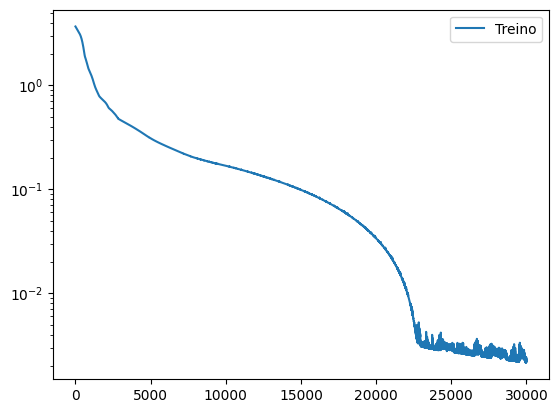

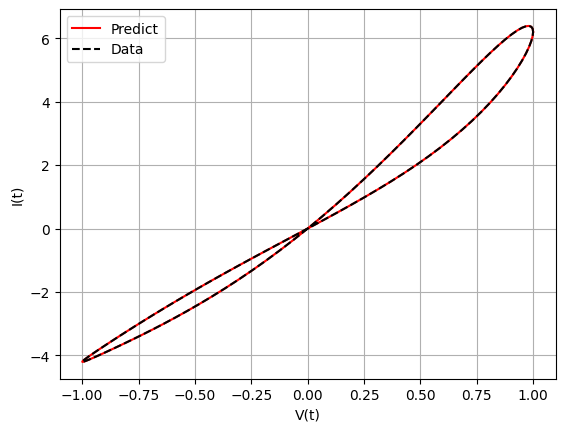

lr:0.0001 neuronio_ 10 camadas 5 fun_activationSineActivation() 
 Parametros : a = 3.9999754428863525, b = 1.116348385810852, C_1 =3.5832433700561523, C_2 = 1.791599988937378 |


In [6]:
traino(lr_=0.0001,neuronio_=10,camadas=5,fun_activation=SineActivation(),epochs=30000)